### Remarks

Dear Kai,

The module is working overall fine. I just want to clear my misconceptions if there is any;
1. Why doesn't it read all the information which is in the dataset, it only reads few variables?
2. if you see I first piped vol[0] without assigning any particular name to it, it generated x,y and z coords in whole dataset, e,g vol[1] also contains x,y and z.
3. I want you to have a look at cappi given at bottom, there is some kind of spoke there in the figure, while the old cappi plot of the same dataset with which I worked in June, 2021 doesn't have that spoke.

In [1]:
import wradlib as wrl
import xarray as xr
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%time
vol = wrl.io.rainbow.open_rainbow_dataset('2017030700000300dBuZ.vol', reindex_angle=False)
vol

CPU times: user 358 ms, sys: 12.6 ms, total: 371 ms
Wall time: 396 ms


<wradlib.RadarVolume>
Dimension(s): (sweep: 14)
Elevation(s): (0.5, 1.5, 2.4, 3.3, 4.3, 5.2, 6.2, 7.5, 8.7, 10.0, 12.0, 14.0, 16.7, 19.5)

In [3]:
#swp = vol[0].pipe(wrl.georef.georeference_dataset) ## R.1

In [4]:
swp0 = vol[0]
swp = swp0.pipe(wrl.georef.georeference_dataset)

In [22]:
vol[1]

<xarray.Dataset>
Dimensions:     (azimuth: 187, range: 480)
Coordinates: (12/15)
  * azimuth     (azimuth) float64 276.2 278.1 280.0 282.0 ... 271.6 273.5 275.4
    elevation   (azimuth) float64 1.5 1.5 1.5 1.5 1.5 ... 1.5 1.5 1.5 1.5 1.5
  * range       (range) float32 250.0 750.0 1.25e+03 ... 2.392e+05 2.398e+05
    time        datetime64[ns] 2017-03-07T00:00:24
    rtime       (azimuth) datetime64[ns] 2017-03-07T00:00:24.047500 ... 2017-...
    longitude   float64 102.6
    ...          ...
    x           (azimuth, range) float64 -248.5 -745.4 ... -2.379e+05 -2.383e+05
    y           (azimuth, range) float64 26.87 80.6 134.3 ... 2.26e+04 2.264e+04
    z           (azimuth, range) float64 262.5 275.6 ... 9.88e+03 9.907e+03
    gr          (azimuth, range) float64 249.1 748.9 ... 2.389e+05 2.394e+05
    rays        (azimuth, range) float64 276.2 276.2 276.2 ... 275.4 275.4 275.4
    bins        (azimuth, range) float32 250.0 750.0 ... 2.392e+05 2.398e+05
Data variables:
    DBTH        (azimuth, range) float32 57.0 59.5 38.5 44.5 ... nan nan nan nan
Attributes:
    fixed_angle:  1.5

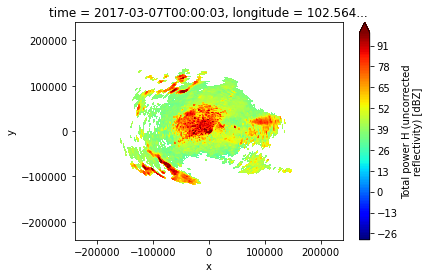

In [5]:
swp.DBTH.plot.contourf(x='x',y='y',cmap='jet',levels=range(-30,100,1))

In [11]:
import pandas as pd
from matplotlib import axes
from matplotlib.ticker import NullFormatter
import cartopy.crs as ccrs
import cartopy.feature as feat
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [34]:
final_ele = len(vol) - 1
print(final_ele)
print(vol[final_ele].fixed_angle)

13
19.5


Iterating over sweeps and stacking points
Creating 3D Grid
Interpolating Data into 3D Grids
Gridding Complete
Plotting Max-Z
0:00:44.514955


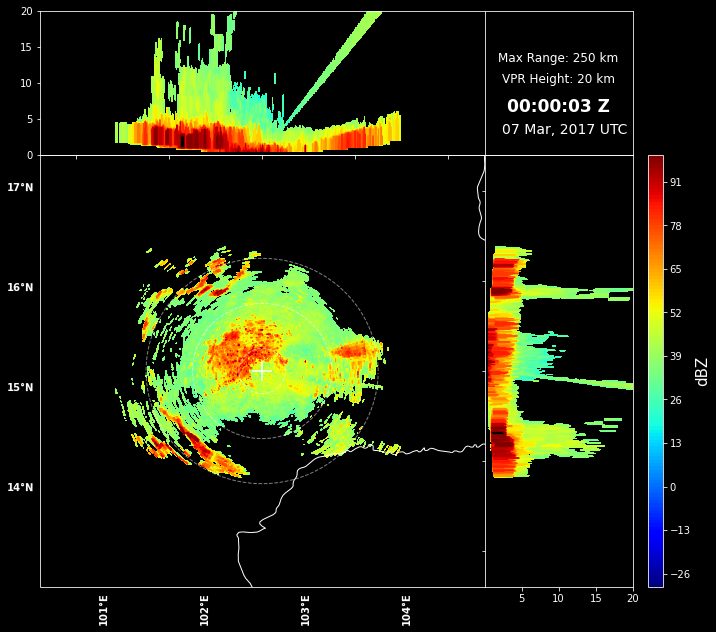

In [39]:
tstart = dt.datetime.now()
vol = wrl.io.rainbow.open_rainbow_dataset('2017030700000300dBuZ.vol', reindex_angle=False)
print('Iterating over sweeps and stacking points')
swp_list = []
print('Creating 3D Grid')
for v in vol:
     # georeference and stack dimensions
    swp = v.pipe(wrl.georef.georeference_dataset).stack(points=["azimuth", "range"])
    swp_list.append(swp)
# concat sweeps to volume
vol0 = xr.concat(swp_list, dim="points")
# Create XYZ Coordinate DataArray
xyz = xr.concat([vol0.x, vol0.y, vol0.z], dim="xyz").transpose()
# Create Target 3D Grid
trgx = np.linspace(xyz[:, 0].min(),xyz[:, 0].max(), 500)
trgy = np.linspace(xyz[:, 1].min(),xyz[:, 1].max(), 500)
trgz = np.linspace(0, 20000, 80)
yy, hh, xx = np.meshgrid(trgy,trgz,trgx)
trgxyz = np.stack([xx.flatten(), yy.flatten(), hh.flatten()]).T
# Create Gridder/Interpolator
trgshape=xx.shape
gridder = wrl.vpr.CAPPI(polcoords=xyz,
                     gridcoords=trgxyz,
                     gridshape=trgshape,
                     maxrange=float(vol[0].range[0])*1e3,
                     minelev=0,
                     maxelev=vol[final_ele].fixed_angle,
                     ipclass=wrl.ipol.Nearest)
print('Interpolating Data into 3D Grids')
# Interpolate Data into 3D Grid
crtd_ref = vol0.DBTH
vol_zh = np.ma.masked_invalid(gridder(crtd_ref.values).reshape(trgshape))
trgx = trgxyz[:, 0].reshape(trgshape)[0, 0, :]
trgy = trgxyz[:, 1].reshape(trgshape)[0, :, 0]
trgz = trgxyz[:, 2].reshape(trgshape)[:, 0, 0]
print('Gridding Complete')

print('Plotting Max-Z')

plt.style.use("dark_background")
fig = plt.figure(figsize=(10.3,10))
# define axes
left, bottom, width, height = 0.1, 0.1, 0.6, 0.2
left, bottom, width, height = 0.1, 0.1, 0.6, 0.2
ax_xy = plt.axes((left, bottom, width, width),
                 projection=ccrs.AzimuthalEquidistant(float(swp.longitude),
                                                      float(swp.latitude)))
ax_x = plt.axes((left, bottom + width, width, height))
ax_y = plt.axes((left + width, bottom, height, width))
ax_cnr = plt.axes((left+width, bottom + width, left+left,height))
ax_cb = plt.axes((left + width + height + 0.02, bottom, 0.02, width))

# set axis label formatters
ax_x.xaxis.set_major_formatter(NullFormatter())
ax_y.yaxis.set_major_formatter(NullFormatter())
ax_cnr.yaxis.set_major_formatter(NullFormatter())
ax_cnr.xaxis.set_major_formatter(NullFormatter())

# # label axes

# draw CAPPI
plt.sca(ax_xy)
xy = ax_xy.contourf(trgx,trgy,vol_zh.max(axis=0),cmap='jet',levels=range(-30,100,1))
gl = ax_xy.gridlines(crs=ccrs.PlateCarree(), linewidth=1, color='black', alpha=0.5, 
                     linestyle='--', draw_labels=True)
gl.xlabels_top = False
gl.ylabels_left = True
gl.ylabels_right=False
gl.xlines = False
gl.ylines = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'weight': 'bold'}
gl.ylabel_style = {'weight': 'bold'}
ax_xy.add_feature(feat.BORDERS,color='w')
[ax_xy.plot(r * np.cos(np.arange(0,360) * np.pi / 180), 
         r * np.sin(np.arange(0,360) * np.pi / 180), 'w--', linewidth=1, alpha=0.5) for r in [25e3,75e3,125e3]]
# ax_xy.set_xlim(-125e3,125e3)
# ax_xy.set_ylim(-125e3,125e3)
ax_xy.plot([0,0],[-10e3,10e3],'w-')
ax_xy.plot([-10e3,10e3],[0,0],'w-')

# draw colorbar
cb = plt.colorbar(xy, cax=ax_cb)
cb.set_label('dBZ',fontsize=15)

plt.sca(ax_x)
plt.contourf(trgx/1e3,trgz/1e3,vol_zh.max(axis=1),cmap='jet',levels=range(-30,100,1))

plt.sca(ax_y)
plt.contourf(trgz/1e3,trgy/1e3,vol_zh.max(axis=2).T,cmap='jet',levels=range(-30,100,1))
# plt.xlim(0,20)
ax_y.set_xticks([5,10,15,20])
# plt.grid(axis='x')

plt.sca(ax_cnr)
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    left=False,
    right=False,
    labelbottom=False)
# labels along the bottom edge are off
plt.text(0.09,0.65,f'Max Range: {int(vol[0].range[0])} km',fontsize=12)
plt.text(0.12,0.5,'VPR Height: 20 km',fontsize=12)
plt.text(0.15,0.3,pd.to_datetime(vol[0].time.values).strftime('%H:%M:%S Z'),weight='bold',fontsize=17)
plt.text(0.12,0.15,pd.to_datetime(vol[0].time.values).strftime('%d %b, %Y UTC'),fontsize=14)
ax_xy.set_aspect('auto')
# plt.savefig('plots/'+'Shp_Max-Z_'+str(filename[-29:82])+'.jpg',dpi=200,bbox_inches='tight')
print(dt.datetime.now()-tstart)

### Imported from https://github.com/syedhamidali/cappi/blob/main/CAPPI_WRADLIB.ipynb
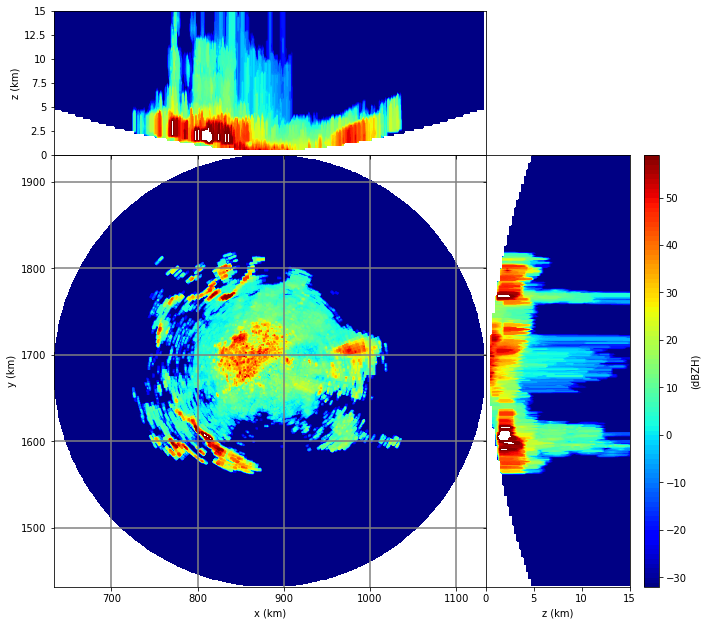